In [3]:

from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langgraph.graph.message import AnyMessage
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages, MessagesState
from typing import Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import DuckDuckGoSearchRun
import operator
from pydantic import BaseModel
from pydantic import Field
from typing import List




In [17]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
)


In [25]:
class Analyst(BaseModel):
    affiliation:str = Field(description='Primary Affiliation of the analyst')
    name: str = Field(description='name of the analyst')
    role: str = Field(description='role of the analyst in the context of the topic')
    description:str = Field(description='description of the analyst focus, concerns and motives')
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
class Perspective(BaseModel):
    analysts: List[Analyst] = Field(description='Comprehensive list of analyst with their roles and affiliatoins')
    
class GeneralAnalystState(TypedDict):
    topic: str
    max_analyst: str
    human_analyst_feedback: str
    analysts: List[Analyst]
    

In [6]:
# prompt
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

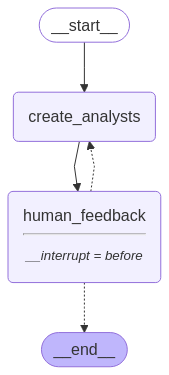

In [29]:
# node
def create_analysts(state: GeneralAnalystState):
    topic = state['topic']
    max_analyst = state['max_analyst']
    human_analyst_feedback = state.get('human_analyst_feedback','')
    structured_model = model.with_structured_output(Perspective)
    system_message = analyst_instructions.format(topic=topic,
                                                human_analyst_feedback=human_analyst_feedback,
                                                max_analyst=max_analyst)
    message = [SystemMessage(analyst_instructions),
               HumanMessage('Generate a set of Analyst')]
    output = structured_model.invoke(message)
    return {'analysts':output.analysts}

def human_feedback(state: GeneralAnalystState):
    pass

def should_continue(state: GeneralAnalystState):
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return 'create_analyst'    
    return END
    


builder = StateGraph(GeneralAnalystState)

builder.add_node('create_analysts', create_analysts)
builder.add_node('human_feedback', human_feedback)
builder.add_edge(START, 'create_analysts')
builder.add_edge('create_analysts', 'human_feedback')
builder.add_conditional_edges(
    'human_feedback',
    should_continue,
    ['create_analysts', END]
)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory, interrupt_before=['human_feedback'])
graph

In [19]:
pers = model.with_structured_output(Perspective).invoke('Generate a set of analyst')

In [21]:
pers.analyst

[Analyst(affiliation='ThinkTankA', name='John Smith', role='National Security Analyst', description='Cybersecurity threats from a national security perspective'),
 Analyst(affiliation='BankOfAmerica', name='Jane Doe', role='Financial Analyst', description='Cybersecurity threats from a financial perspective')]